<a target="_blank" href="https://colab.research.google.com/github/pywavelet/pywavelet/blob/main/docs/examples/example_signals.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# EMRI, Galactic Binary, and MBH Transformation examples

We generate the signals using the `fastemriwaveforms`, `bbhx` and `gbbgpu` packages.
The signals are saved to an HDF5 file. 

Alternatively, you can use data from the [LISA Data Challenge](https://lisa-ldc.lal.in2p3.fr/challenge1a). 



In [ ]:
## Installations (uncomment and run)
# !apt-get install liblapacke-dev libgsl-dev
# !ln -s /usr/lib/x86_64-linux-gnu/libhdf5_serial_hl.so /usr/lib/x86_64-linux-gnu/libhdf5_hl.so
# !ln -s /usr/lib/x86_64-linux-gnu/libhdf5_serial.so /usr/lib/x86_64-linux-gnu/libhdf5.so
# !pip install fastemriwaveforms lisaanalysistools bbhx gbgpu h5py pywavelet

In [1]:
import numpy as np
import h5py
import warnings
from typing import Tuple
import os
import scipy
from scipy.signal.windows import tukey

warnings.filterwarnings("ignore")

S_DAY = 60 * 60 * 24  # seconds in a day
N = 2**18
DATA_FILE = "data.h5"

RADLER_DATASETS = dict(
    MBH="LDC1-1_MBHB_v1_1_FD_noiseless.hdf5",
    EMRI="LDC1-2_EMRI_v1_noiseless.hdf5",
    VGB="LDC1-3_VGB_v1_FD_noiseless.hdf5",
)


def generate_emri(fname="EMRI.h5") -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate an EMRI frequency domain waveform.
    Returns:
        Tuple[np.ndarray, np.ndarray]: (frequency array, waveform)
    """
    from few.waveform import GenerateEMRIWaveform
    from few.trajectory.inspiral import EMRIInspiral
    from few.utils.utility import get_p_at_t

    # EMRI parameters
    Tobs = 1.0  # observation time
    dt = 10.0  # time interval
    eps = 0  # mode content percentage
    M = 1e6  # central object mass
    mu = 10.0  # secondary object mass
    e0 = 0.6  # eccentricity
    a = 0.1  # spin parameter (ignored for Schwarzschild)
    x0 = 1.0  # ignored in Schwarzschild waveform

    # Angles and phases (all in radians)
    qS = np.pi / 3
    phiS = np.pi / 3
    qK = np.pi / 3
    phiK = np.pi / 3
    Phi_phi0 = np.pi / 3
    Phi_theta0 = 0.0
    Phi_r0 = np.pi / 3
    dist = 1.0

    # Common waveform kwargs
    waveform_kwargs = {"T": Tobs, "dt": dt, "eps": eps}

    # Compute the initial semi-latus rectum (p0)
    traj_module = EMRIInspiral(func="SchwarzEccFlux")
    p0 = get_p_at_t(
        traj_module,
        Tobs * 0.99,
        [M, mu, 0.0, e0, 1.0],
        index_of_p=3,
        index_of_a=2,
        index_of_e=4,
        index_of_x=5,
        traj_kwargs={},
        xtol=2e-12,
        rtol=8.881784197001252e-16,
        bounds=None,
    )

    # Injection parameters:
    # [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
    emri_injection_params = [
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]

    # Create a time-domain generator to get the correct FFT grid.
    td_gen = GenerateEMRIWaveform(
        "FastSchwarzschildEccentricFlux",
        sum_kwargs=dict(pad_output=False, odd_len=True),
        return_list=True,
    )
    h_td = td_gen(*emri_injection_params, **waveform_kwargs)[
        0
    ]  # get + polarization
    h_fd = np.fft.fftshift(np.fft.fft(h_td)) * dt
    N = len(h_td)
    freq_all = np.fft.fftshift(np.fft.fftfreq(N, dt))
    positive_mask = freq_all >= 0.0
    freq = freq_all[positive_mask]
    hf_fd = h_fd[positive_mask]  # Grab only +ve frequencies

    # save EMRI data
    with h5py.File(fname, "a") as f:
        grp = f.create_group("EMRI")
        grp.create_dataset("freq", data=freq)
        grp.create_dataset("hf", data=hf_fd)


def generate_gb(fname) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a Galactic Binary signal.
    Returns:
        Tuple[np.ndarray, np.ndarray]: (frequency array, waveform)
    """
    from gbgpu.gbgpu import GBGPU
    from lisatools.utils.constants import YRSID_SI

    gb = GBGPU()
    # Galactic Binary parameters
    amp = 2e-23  # amplitude
    f0 = 3e-3  # initial frequency
    fdot = 7.538331e-18
    fddot = 0.0
    phi0 = 0.1  # initial phase
    inc = 0.2  # inclination
    psi = 0.3  # polarization angle
    lam = 0.4  # ecliptic longitude
    beta = 0.5  # ecliptic latitude

    gb.run_wave(amp, f0, fdot, fddot, phi0, inc, psi, lam, beta, N=2**16)
    f, hf = gb.freqs[0], gb.A[0]  # A  --> A channel

    with h5py.File(fname, "a") as f_out:
        grp = f_out.create_group("GB")
        grp.create_dataset("freq", data=f)
        grp.create_dataset("hf", data=hf)


def generate_mbh(fname) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate an MBH (massive black hole) waveform.
    Returns:
        Tuple[np.ndarray, np.ndarray]: (frequency array, waveform)
    """
    from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
    from lisatools.utils.constants import PC_SI

    wave_gen = PhenomHMAmpPhase()
    # MBH parameters
    m1 = 2e6
    m2 = 7e5
    chi1 = 0.5
    chi2 = 0.7
    dist = 3000 * 1e9 * PC_SI
    phi_ref = 0.6
    f_ref = 0.0
    t_ref = 1e6  # seconds
    length = 2**16

    wave_gen(m1, m2, chi1, chi2, dist, phi_ref, f_ref, t_ref, length)

    fd = wave_gen.amp[0, 0] * np.exp(
        1j * -wave_gen.phase[0, 0]
    )  # grabbing [(2,2), +pol]
    freq = wave_gen.freqs_shaped[0, 0]

    with h5py.File(fname, "a") as f_out:
        grp = f_out.create_group("MBH")
        grp.create_dataset("freq", data=freq)
        grp.create_dataset("hf", data=fd)


def load_radler_data(key, fname):
    from pywavelet.types import TimeSeries

    load_fname = f"radler/{RADLER_DATASETS[key]}"

    with h5py.File(load_fname, "r") as f:
        tdi_data = f["H5LISA/PreProcess/TDIdata"][:]
        t, x, y, z = tdi_data.T
        ts = TimeSeries(data=x, time=t)

    fd = ts.to_frequencyseries()
    with h5py.File(fname, "a") as f_out:
        grp = f_out.create_group(key)
        grp.create_dataset("freq", data=fd.freq)
        grp.create_dataset("hf", data=fd.data)


def main():
    if not os.path.exists(DATA_FILE):
        # Generate signals
        generate_emri(DATA_FILE)
        if not os.path.exists("radler"):
            generate_gb(DATA_FILE)
            generate_mbh(DATA_FILE)
        else:
            load_radler_data("VGB", DATA_FILE)
            load_radler_data("MBH", DATA_FILE)

    # print keys in the data file
    with h5py.File(DATA_FILE, "r") as f:
        print("Available datasets in the data file:")
        for key in f.keys():
            print(f"- {key}")


if __name__ == "__main__":
    main()

Available datasets in the data file:
- EMRI
- MBH
- VGB


Next we load the data, compute the WDM transforms and plot the results.

In [16]:
import h5py
import numpy as np

from lisatools.sensitivity import get_sensitivity

from pywavelet.types import FrequencySeries, Wavelet, TimeSeries
from dataclasses import dataclass
from typing import Dict
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter

import matplotlib.pyplot as plt

# Set the desired RC parameters
rc_params = {
    "xtick.direction": "in",  # Mirrored ticks (in and out)
    "ytick.direction": "in",
    "xtick.top": True,  # Show ticks on the top spine
    "ytick.right": True,  # Show ticks on the right spine
    "xtick.major.size": 6,  # Length of major ticks
    "ytick.major.size": 6,
    "xtick.minor.size": 4,  # Length of minor ticks
    "ytick.minor.size": 4,
    "xtick.major.pad": 4,  # Padding between tick and label
    "ytick.major.pad": 4,
    "xtick.minor.pad": 4,
    "ytick.minor.pad": 4,
    "font.size": 14,  # Overall font size
    "axes.labelsize": 16,  # Font size of axis labels
    "axes.titlesize": 18,  # Font size of plot title
    "xtick.labelsize": 12,  # Font size of x-axis tick labels
    "ytick.labelsize": 12,  # Font size of y-axis tick labels
    "xtick.major.width": 2,  # Thickness of major ticks
    "ytick.major.width": 2,  # Thickness of major ticks
    "xtick.minor.width": 1,  # Thickness of minor ticks
    "ytick.minor.width": 1,  # Thickness of minor ticks
    "lines.linewidth": 3,  # Default linewidth for lines in plots
    "patch.linewidth": 4,  # Default linewidth for patches (e.g., rectangles, circles)
    "axes.linewidth": 2,  # Default linewidth for the axes spines
}

# Apply the RC parameters globally
plt.rcParams.update(rc_params)

COLORS = dict(MBH="#17becf", EMRI="#c9c9c9", VGB="#d62728")


@dataclass
class PlotData:
    freqseries: FrequencySeries
    wavelet: Wavelet
    label: str


def load_data() -> Dict[str, PlotData]:
    """
    Load data from HDF5 files.
    Returns:
        Tuple[np.ndarray, np.ndarray]: (frequency array, waveform)
    """
    # Load the data from the HDF5 file
    keys = ["EMRI", "VGB", "MBH"]
    data = {}
    with h5py.File("data.h5", "r") as f:
        for key in keys:
            freqseries = FrequencySeries(f[key]["hf"][:], f[key]["freq"][:])
            wdm = freqseries.to_wavelet(Nf=1024)
            data[key] = PlotData(
                freqseries=freqseries, wavelet=wdm, label=key.upper()
            )
    return data


def generate_plot(data: Dict[str, PlotData]):
    # Create figure and gridspec
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(
        2, 3, figure=fig, height_ratios=[1, 1]
    )  # 2 rows, 3 columns

    # Create subplots
    ax0 = fig.add_subplot(gs[0, :])  # Row 1: spans all 3 columns
    ax1 = fig.add_subplot(gs[1, 0])  # Row 2, Column 1
    ax2 = fig.add_subplot(gs[1, 1])  # Row 2, Column 2
    ax3 = fig.add_subplot(gs[1, 2])  # Row 2, Column 3
    axs = [ax1, ax2, ax3]

    ### Plot characteristic strain

    f_fixed = np.logspace(-4, -1, 1000)
    sensitivity = get_sensitivity(
        f_fixed, sens_fn="LISASens", return_type="char_strain"
    )
    ax0.loglog(
        f_fixed, sensitivity, "k--", label="LISA Sensitivity", zorder=-5
    )
    ax0.set_xlim(1e-4, 1e-1)
    ax0.set_ylim(bottom=10**-22, top=10**-18)
    # reduce padding for xlabel
    ax0.set_xlabel(r"$f$ [Hz]", labelpad=-5)
    ax0.set_ylabel(r"Characteristic Strain")

    # rearrange data [EMRI, MBH, GB]
    data = {k: data[k] for k in ["EMRI", "MBH", "VGB"]}

    for k, d in data.items():
        f, hf = d.freqseries.freq, d.freqseries.data
        zorder = -10 if k == "EMRI" else 10
        ax0.loglog(
            f[1:],
            (np.abs(hf) * f)[1:],
            label=f"{d.label}",
            color=COLORS[k],
            zorder=zorder,
        )

    ax0.legend(frameon=False)

    # ### Plot WDMs (share colorbar)
    log_norm = LogNorm(vmin=10**-31, vmax=10**-19)

    for i, (k, d) in enumerate(data.items()):
        kwgs = dict(
            absolute=True,
            zscale="log",
            cmap="inferno",
            ax=axs[i],
            norm=log_norm,
            show_gridinfo=False,
            show_colorbar=False,
        )
        if i == 2:
            kwgs["show_colorbar"] = True
        d.wavelet.plot(**kwgs)
        axs[i].text(
            0.05,
            0.95,
            d.label,
            color=COLORS[k],
            transform=axs[i].transAxes,
            verticalalignment="top",
            # extra bold font
            fontweight="bold",
        )
        if k == "VGB":
            axs[i].set_ylim(0.001, 0.008)
        elif k == "MBH":
            axs[i].set_ylim(0.0001, 0.003)
            axs[i].set_xlim(173 * S_DAY, 340 * S_DAY)

    ax1.set_ylabel(r"$f$ [Hz]")
    ax2.set_ylabel("")
    ax3.set_ylabel("")
    ax1.set_ylim(top=0.02)

    cbar = plt.gca().images[-1].colorbar

    # cbar = ax3.collections[0].colorbar
    cbar.set_label(r"")
    cbar.ax.yaxis.label.set(rotation=0, ha="right", va="bottom")
    cbar.ax.yaxis.set_tick_params(rotation=0)

    # make yticks only use 2 digits, and use only 3 ticks
    for ax in axs:
        ax.set_xlabel(r"$t$ [days]")
        ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=3))
        ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4, prune="both"))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    return fig, axs

In [3]:
data = load_data()

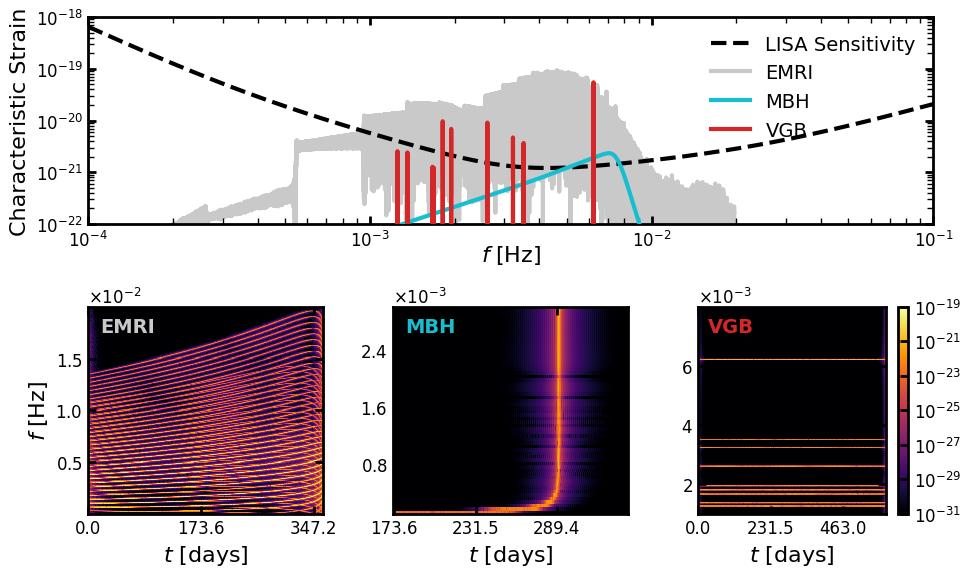

In [17]:
fig, axs = generate_plot(data)
plt.tight_layout()
plt.savefig("example_signals.png", dpi=300, bbox_inches="tight")

![](example_transforms.png)

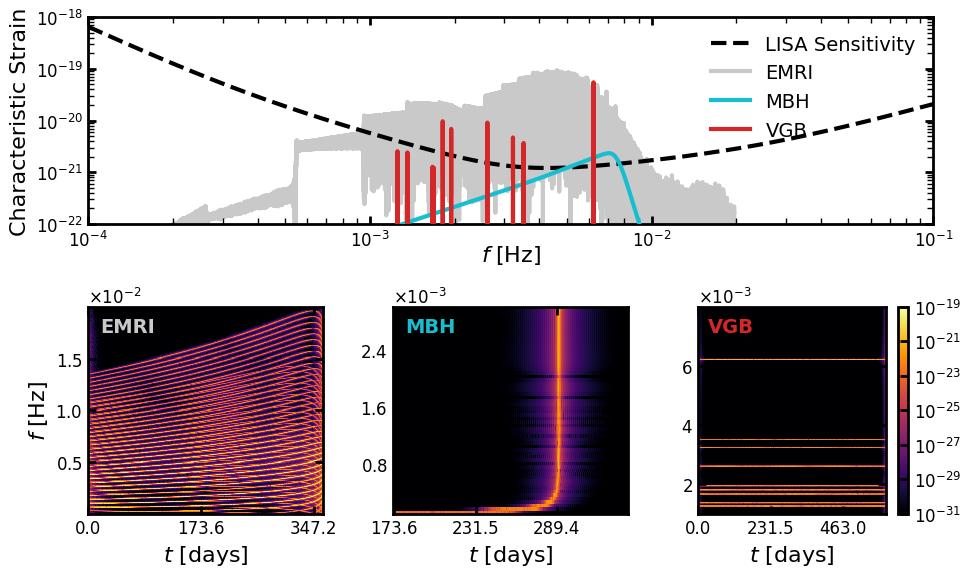

In [18]:
fig, axs = generate_plot(data)
plt.tight_layout()
plt.savefig("example_signals.pdf", dpi=300, bbox_inches="tight")